# X/Y/Xmodem file transfer tool

    Xmodem：这种古老的传输协议速度较慢，但由于使用了CRC错误侦测方法，传输的准确率可高达99.6%。
    XModem协议介绍：XModem是一种在串口通信中广泛使用的异步文件传输协议，分为XModem和1k-XModem协议两种，前者使用128字节的数据块，后者使用1024字节即1k字节的数据块。
    
    Ymodem：这是Xmodem的改良版，使用了1024位区段传送，速度比Xmodem要快。
    
    Zmodem：Zmodem采用了串流式（streaming）传输方式，传输速度较快，而且还具有自动改变区段大小和断点续传、快速错误侦测等功能。这是目前最流行的文件传输协议。
    
    IAP是In Application Programming的首字母缩写，IAP是用户自己的程序在运行过程中对User Flash的部分区域进行烧写，目的是为了在产品发布后可以方便地通过预留的通信口对产品中的固件程序进行更新升级。

## Xmodem协议-1

    1. XMODEM协议是一种串口通信中 广泛用到的异步文件传输协议。分为标准Xmodem和1k-Xmodem两种，前者以128字节块的形式传输数据，后者字节块为1k即1024字节，并且每个块都使用一个校验和过程来进行错误检测。在校验过程中如果接收方关于一个块的校验和与它在发送方的校验和相同时，接收方就向发送方发送一个确认字节 (ACK)。由于Xmodem需要对每个块都进行认可，这将导致性能有所下降，特别是延时比较长的场合，这种协议显得效率更低。
    除了Xmodem，还有Ymodem，Zmodem协议。他们的协议内容和Xmodem类似，不同的是Ymodem允许批处理文件传输，效率更高；Zmodem则是改进的了Xmodem，它只需要对损坏的块进行重发，其它正确的块不需要发送确认字节。减少了通信量.

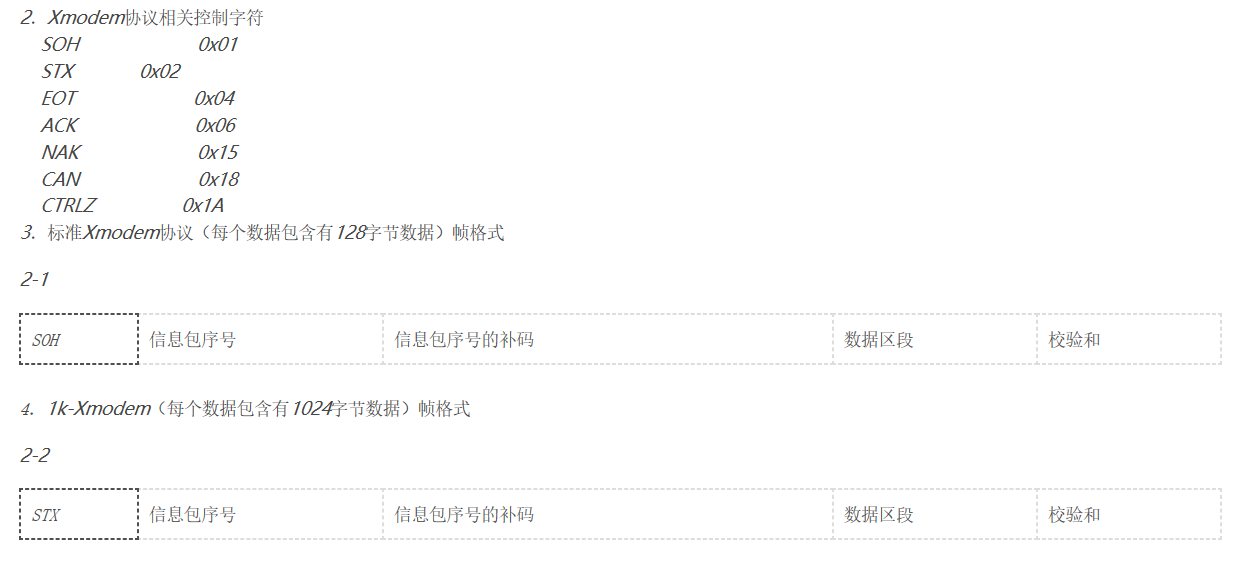

In [1]:
from IPython.display import Image
Image(filename='xmodem.png', width=800, height=300)

## Xmodem协议-2
    5．数据包说明
    对于标准Xmodem协议来说，如果传送的文件不是128的整数倍，那么最后一个数据包的有效内容肯定小于帧长，不足的部分需要用CTRL- Z(0x1A)来填充。这里可能有人会问，如果我传送的是bootloader工程生成的.bin文件，mcu收到后遇到0x1A字符会怎么处理？其实如 果传送的是文本文件，那么接收方对于接收的内容是很容易识别的，因为CTRL-Z不是前128个ascii码，不是通用可见字符，如果是二进制文件，mcu其实也不会把它当作代码来执行。哪怕是excel文件等，由于其内部会有些结构表示各个字段长度等，所以不会读取多余的填充字符。否则 Xmodem太弱了。对于1k-Xmodem，同上理。
    6．如何启动传输？
    传输由接收方启动，方法是向发送方发送"C"或者NAK(注意，这里提到的NAK是用来启动传输的。以下我们会看到NAK还可以用来对数据产生重传的机 制)。接收方发送NAK信号表示接收方打算用累加和校验；发送字符"C"则表示接收方想打算使用CRC校验（具体校验规则下文Xmodem源码，源码胜于雄辩)。
    7．传输过程
    当接收方发送的第一个"C"或者NAK到达发送方，发送方认为可以发送第一个数据包，传输已经启动。发送方接着应该将数据以每次128字节的数据加上包头，包号，包号补码，末尾加上校验和，打包成帧格式传送。
    发送方发了第一包后就等待接收方的确认字节ACK，收到接收方传来的ACK确认，就认为数据包被接收方正确接收，并且接收方要求发送方继续发送下一个包； 如果发送方收到接收方传来的NAK(这里，NAK用来告诉发送方重传，不是用来启动传输)字节，则表示接收方请求重发刚才的数据包；如果发送方收到接收方传来的CAN字节，则表示接收方请求无条件停止传输。
    8．如何结束传输？
    如果发送方正常传输完全部数据，需要结束传输，正常结束需要发送方发送EOT 字节通知接收方。接收方回以ACK进行确认。当然接收方也可强制停止传输，当接收方发送CAN 字节给发送方，表示接收方想无条件停止传输，发送方收到CAN后，不需要再发送 EOT确认（因为接收方已经不想理它了，呵呵）。
    9．特殊处理
    虽然数据包是以 SOH 来标志一个信息包的起始的，但在 SOH 位置上如果出现EOT则表示数据传输结束，再也没有数据传过来。
    接收方首先应确认数据包序号的完整性，通过对数据包序号取补，然后和数据包序号的补码异或，结果为0表示正确，结果不为0则发送NAK请求重传。
    接收方确认数据包序号正确后，然后检查是否期望的序号。如果不是期望得到的数据包序号，说明发生严重错误，应该发送一个 CAN 来中止传输。
    如果接收到的数据包的包序号和前一包相同，那么接收方会忽略这个重复包，向发送方发出 ACK ，准备接收下一个包。
    接收方确认了信息包序号的完整性和是正确期望的后，只对 128 字节的数据区段进行算术和校验，结果与帧中最后一个字节（算术校验和）比较，相同发送 ACK，不同发送 NAK。
    10．校验和的说明
    Xmodem协议支持2种校验和，它们是累加和与CRC校验。
    当接收方一开始启动传输时发送的是NAK，表示它希望以累加和方式校验。
    当接收方一开始启动传输时发送的是字符“C”，表示它希望以CRC方式校验。
    可能有人会问，接收方想怎么校验发送方都得配合吗，难道发送方必须都支持累加和校验和CRC校验？事实上Xmodem要求支持CRC的就必须同时支持累加和，如果发送方只支持累加和，而接收方用字符“C”来启动，那么发送方只要不管它，当接收方继续发送“C”，三次后都没收到应答，就自动会改为发送 NAK，因为它已经明白发送方可能不支持CRC校验，现在接收方改为累加和校验和发送方通讯。发送方收到NAK就赶紧发送数据包响应。

## Ymodem协议

    由XMODEM演变来，效率可靠性高，包=128*8B；一次传输可发送或接受几个文件。
    XMODEM1K本质上是XMODEM CRC1K（1024字节）的数据包。在某些系统中，它也可以被称为YMODEM。有些通信软件程序，著名的Procomm的1.x版本中，也将XMODEM-1K 称为YMODEM，但在Procomm的2.0版本中不再称XMODEM-1K为YMODEM。
    YMODEM -G：YMODEM-G是一种YMODEM的变种。它被设计成用于支持错误控制的调制解调器。该协议不提供软件纠错或恢复，但预计调制解调器提供的服务。这是一个流媒体协议，在一个连续的数据流上发送和接收1K的数据包，直显式停止。每块被发送后，它不会等待肯定的确认，而是快速连续地发送块。如果任何块传输失败，本次传输将会失败退出。
    
    文件传输过程的开启：
    （1）开启是由接收方开启传输，它发一个大写字母C开启传输。然后进入等待（SOH）状态，如果没有回应，就会超时退出。
    （2）发送方开始时处于等待过程中，等待C。收到C以后，发送（SOH）数据包开始信号，发送序号（00），补码（FF），“文件名”，“空格”“文件大小”“除去序号外，补满128字节”，CRC校验两个字节。进入等待（ACK）状态。
    （3）接收方收到以后，CRC校验满足，则发送ACK。发送方接收到ACK，又进入等待“文件传输开启”信号，即重新进入等待“C”的状态。
 
    （4）前面接收方只是收到了一个文件名，限制正式开启文件传输，Ymodem支持128字节和1024字节一个数据包。128字节以（SOH）开始，1024字节以（STX）开始。
    接收方又发出一个“C”信号，开始准备接收文件。进入等待“SOH”或者“STX”状态。
    （5）发送接收到“C”以后，发送数据包，（SOH）（01序号）（FE补码）（128位数据）（CRC校验），等待接收方“ACK”。
    （6）文件发送完以后，发送方发出一个“EOT”信号，接收方也以“ACK”回应。
    然后接收方会再次发出“C”开启另一次传输，若接着发送方会发出一个“全0数据包”，接收方“ACK”以后，本次通信正式结束。
    （7）当然YMODEM相对于XMODEM改进的地方就在于传输再次开启以后，又可以发送另外一个文件，即一次传输允许发送多个文件。
    
    所用到的符号
    #define MODEM_SOH 0x01 //数据块起始字符
    #define MODEM_STX 0x02 //1028字节开始
    #define MODEM_EOT 0x04 //文件传输结束
    #define MODEM_ACK 0x06 //确认应答
    #define MODEM_NAK 0x15 //出现错误
    #define MODEM_CAN 0x18 //取消传输
    #define MODEM_C 0x43   //大写字母Ｃ
    
    CRC计算方法
    in_ptr = mblock->buf; //指向要计算CRC的缓冲区开头
    cksum = 0; //
    for (stat=mblock->len ; stat>0; stat--) //len是所要计算的长度
    {
        cksum = cksum^(int)(*in_ptr++) << 8; //
        for (i=8; i!=0; i--)
        {
            if (cksum & 0x8000)
                cksum = cksum << 1 ^ 0x1021;
            else
                cksum = cksum << 1;
        }
    }

## Zmodem协议

    与上两种不同，可以连续的数据流发送数据，效率更高
    在具体的环境中，通过多次采用的xmodem的传输可以发现，不管是直接传输，还是按照网上 的说法采用rz sz传输，都很难将文件正确传输到嵌入式设备上。当采用zmodem进行传输的时候却发现传输的效率很高，几乎没有失败。
    Zmodem协议有两个显着的特点：它是非常有效的，它提供了类似于YMODEM-G的崩溃恢复机制，Zmodem协议不会等待肯定的确认后，每个块被发送，而是快速连续地发送块。 Zmodem协议传输如果因任何原因被取消或中断，恢复后，先前传送的信息都需要重新发送。